In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

import os

from xception import Xception
from EmbryoDataset import EmbryoDataset

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_train.head()

,Image,Class
0,D3_405.jpg,0
1,D3_523.jpg,0
2,D3_750.jpg,0
3,D3_427.jpg,0
4,D3_042.jpg,0


Let's see how is the label distribution in our dataset:

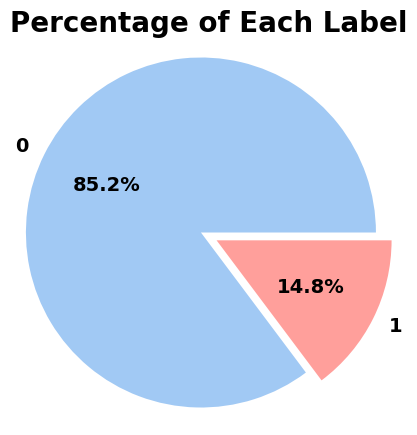

In [4]:
# define Seaborn color palette to use
palette_color = sns.color_palette('pastel')
label_counts = df_train['Class'].value_counts()

# plotting data on chart
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=label_counts.index, colors=[palette_color[0], palette_color[3]], explode=[0, 0.1], autopct='%1.1f%%', textprops={'fontsize': 14, 'fontweight': 'bold'})

plt.title('Percentage of Each Label', fontsize=20, fontweight='bold')
plt.axis('equal')
plt.show()

We can see that our dataset is imbalanced and we need to consider this imbalancy in our analysis. We are going to attribute some weights to each label and use these weights in our loss function.

In [5]:
class_weight = 1 - (label_counts / df_train.shape[0])
class_weight = list(class_weight)

In [6]:
df_test = pd.read_csv('./data/test.csv')
df_test.head()

,ID,Image
0,1,D3_693.jpg
1,2,D3_212.jpg
2,3,D3_724.jpg
3,4,D3_623.jpg
4,5,D3_210.jpg


Let's plot one good and one not good embryo images:

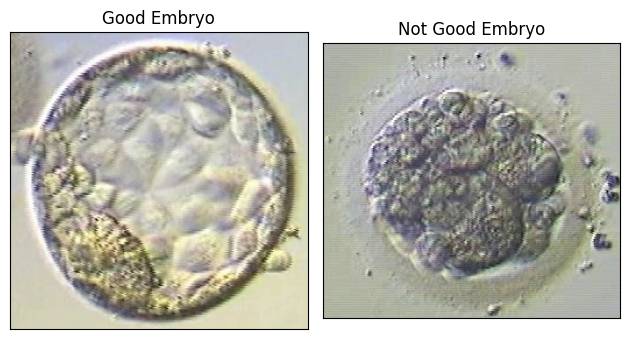

<Figure size 640x480 with 0 Axes>

In [11]:
# Filter images based on class
good_images = df_train[df_train['Class'] == 1]['Image'].tolist()
not_good_images = df_train[df_train['Class'] == 0]['Image'].tolist()

# Randomly select one image from each class
random_good_image = random.choice(good_images)
random_not_good_image = random.choice(not_good_images)

random_good_image = './data/train/' + random_good_image
random_not_good_image = './data/train/' + random_not_good_image

# Plotting randomly selected images
fig, axes = plt.subplots(1, 2)

# Plot random good image
img = plt.imread(random_good_image)
axes[0].imshow(img)
axes[0].set_title('Good Embryo')

axes[0].set_xticks([])  # Remove xticks
axes[0].set_yticks([])  # Remove yticks

# Plot random not good image
img = plt.imread(random_not_good_image)
axes[1].imshow(img)
axes[1].set_title('Not Good Embryo')

axes[1].set_xticks([])  # Remove xticks
axes[1].set_yticks([])  # Remove yticks

plt.tight_layout()
plt.show()

plt.savefig('embryo_images.png')

In [58]:
train_data_path = './data/train'
test_data_path = './data/test'

# create the train_image_label_mapping
train_image_label_mapping = {}

for filename in os.listdir(train_data_path):
    train_image_label_mapping[train_data_path + '/' + filename] = df_train[df_train['Image'] == filename]['Class'].values[0]


# create the test_image_label_mapping
test_image_label_mapping = {}

for filename in os.listdir(test_data_path):
    test_image_label_mapping[test_data_path + '/' + filename] = df_test[df_test['Image'] == filename]['ID'].values[0]

In [59]:
# defining the tranformations for the input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [60]:
# set up the dataset
train_data = EmbryoDataset(train_image_label_mapping, transform=transform)
test_data = EmbryoDataset(test_image_label_mapping, train=False, transform=transform)

In [61]:
# Spliting train data to train and validation parts
valid_size = 0.2
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(valid_size * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Generating dataloaders
train_loader = DataLoader(train_data, batch_size=4, num_workers=2, sampler=train_sampler, pin_memory=True)
valid_loader = DataLoader(train_data, batch_size=4, num_workers=2, sampler=valid_sampler, pin_memory=True)

# test dataloader
test_loader = DataLoader(test_data, shuffle=False, num_workers=2)

In [62]:
# Get cpu or gpu
device = ('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'Using {device} device')

# define the model and use pretrained weights
xception = Xception()
xception.load_state_dict(torch.load('./checkpoints/xception-43020ad28.pth'))

# change the number of output classes
num_ftrs = xception.fc.in_features
xception.fc = nn.Linear(num_ftrs, 2)

xception = xception.to(device)
# print(xception)

In [63]:
criterion = nn.CrossEntropyLoss(weight=torch.Tensor(class_weight)).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(weight=torch.Tensor(class_weight))
optimizer = torch.optim.SGD(xception.parameters(), lr=1e-3, weight_decay=1e-5)

In [64]:
def train_one_epoch(dataloader, model, criterion, optimizer):

    train_loss = 0.0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = criterion(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()

    return train_loss

In [65]:
epochs = 20
min_valid_loss = np.inf

for epoch in range(epochs):

    train_loss = train_one_epoch(train_loader, xception, criterion, optimizer)

    valid_loss = 0.0
    xception.eval()

    with torch.no_grad():
        for X, y in valid_loader:
            X, y = X.to(device), y.to(device)

            pred = xception(X)
            loss = criterion(pred, y)

            valid_loss += loss.item()

    print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader.sampler)} \t\t Validation Loss: {valid_loss / len(valid_loader.sampler)}')
    if min_valid_loss > valid_loss:
        min_valid_loss = valid_loss

        print('Saving...')
        state = {
                'net': xception.state_dict(),
            }
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')

        torch.save(state, './checkpoints/ckpt.pth')

Epoch 1 		 Training Loss: 0.16232897390034937 		 Validation Loss: 0.11679540219761077
Saving...
Epoch 2 		 Training Loss: 0.1520006958217848 		 Validation Loss: 0.10500984151093733
Saving...
Epoch 3 		 Training Loss: 0.1475783742165991 		 Validation Loss: 0.09338448400653544
Saving...
Epoch 4 		 Training Loss: 0.13834735857588903 		 Validation Loss: 0.09276107743027664
Saving...
Epoch 5 		 Training Loss: 0.13447797764092684 		 Validation Loss: 0.08622663902739684
Saving...
Epoch 6 		 Training Loss: 0.1297676789884766 		 Validation Loss: 0.09084198473110086
Epoch 7 		 Training Loss: 0.1263490588448587 		 Validation Loss: 0.09052474415373235
Epoch 8 		 Training Loss: 0.11860670790164954 		 Validation Loss: 0.07395381489325137
Saving...
Epoch 9 		 Training Loss: 0.11661222880883586 		 Validation Loss: 0.07856661050270002
Epoch 10 		 Training Loss: 0.10905274735497576 		 Validation Loss: 0.06996936943115932
Saving...
Epoch 11 		 Training Loss: 0.10346281657084114 		 Validation Loss: 0.0749

Now we can use the weights of the model with the best performance to make predictions on our test data:

In [131]:
# define the model
best_model = Xception(num_classes=2)
best_model.load_state_dict(torch.load('./checkpoints/ckpt.pth')['net'])
best_model = best_model.to(device)

preds = {}

best_model.eval()

with torch.no_grad():
    for X, id in test_loader:
        X = X.to(device)
        pred = best_model(X).argmax(1)


        preds[id.item()] = pred.item()

In [132]:
df_preds = pd.DataFrame.from_dict(preds, orient='index', columns=['Class']).sort_index().reset_index().rename(columns={'index': 'ID'})
df_preds

,ID,Class
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
175,176,1
176,177,0
177,178,1
178,179,0
